In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error


from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.tools.eval_measures import mse
import numpy as np

from datetime import datetime



In [2]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [3]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.index=pd.to_datetime(df.index)

In [6]:
df.head()

,CS_HPA_20_cities,CS_HP,UNEMPLOY,LF_Part,Y10_CMT,Y30_fixed_mortgage_rate,UNEMPLOY_adj,LF_Part_adj,year,month
Date,,,,,,,,,,
2000-01-01,100.589697,100.552,4.5,67.3,6.661000,8.2100,4.5,67.3,2000,Jan
2000-02-01,101.692479,101.339,4.4,67.3,6.519500,8.3250,4.4,67.3,2000,Feb
2000-03-01,102.783829,102.127,4.3,67.3,6.256522,8.2400,4.3,67.3,2000,Mar
2000-04-01,103.996444,102.922,3.7,67.3,5.990526,8.1525,3.7,67.3,2000,Apr
2000-05-01,105.252818,103.677,3.8,67.1,6.440455,8.5150,3.8,67.1,2000,May


In [7]:
target_index ='LF_Part_adj'

In [8]:
index_title ='Labor Force Participation adj'

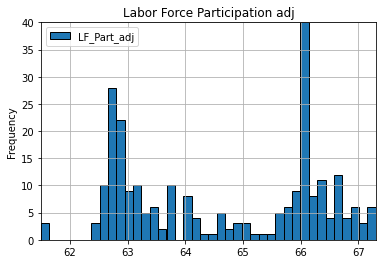

In [9]:
df.plot.hist(y=target_index,grid=True,bins=40,edgecolor='k',title=index_title).autoscale(enable=True,axis='both',tight=True)
plt.show()

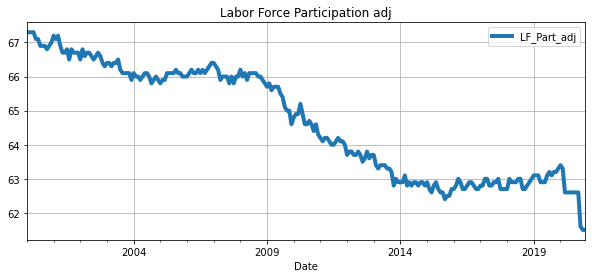

In [10]:
df.plot.line(y=target_index, figsize=(10,4),lw=4, grid=True, title=index_title)
plt.show()

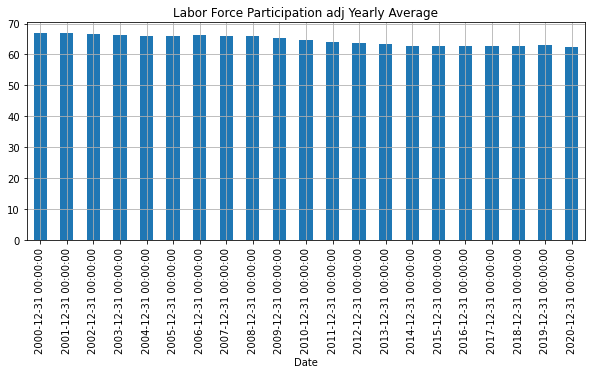

In [11]:
df[target_index].resample('A').mean().plot.bar(figsize=(10,4),grid=True, title=index_title + ' Yearly Average')
plt.show()

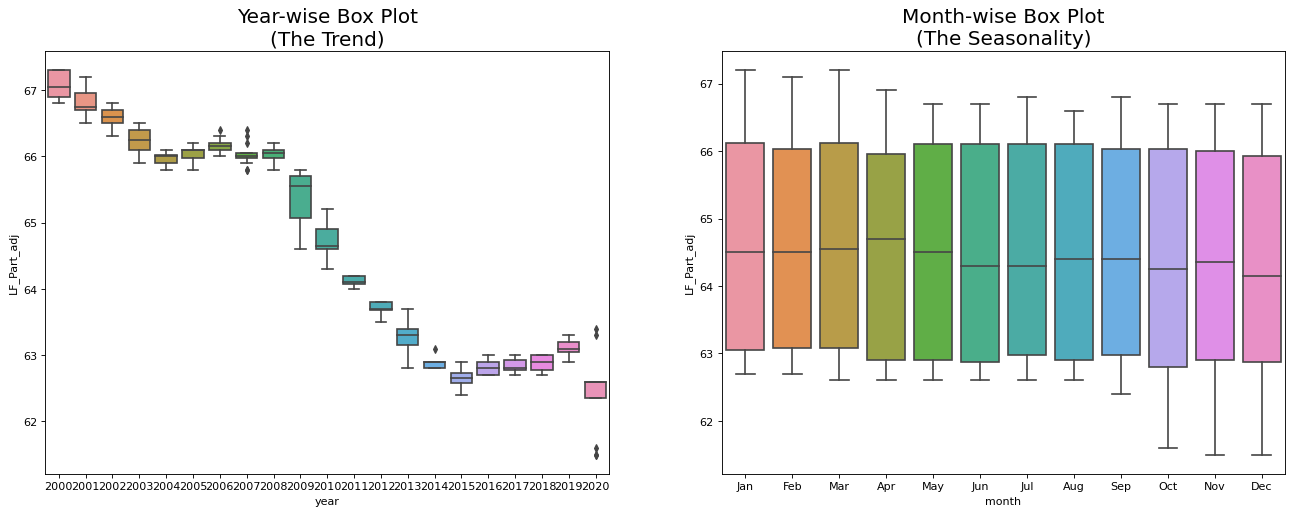

In [12]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=target_index, data=df, ax=axes[0])
sns.boxplot(x='month', y=target_index, data=df.loc[~df.year.isin([2000]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

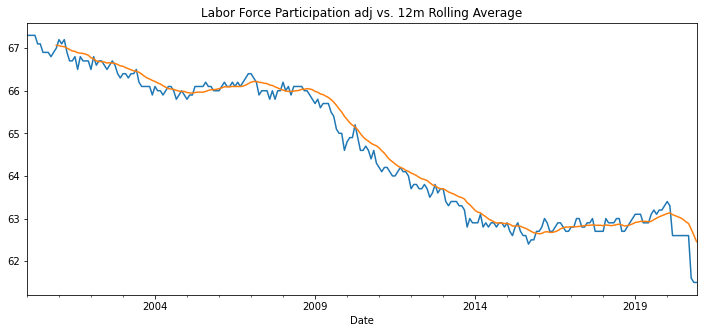

In [13]:
df[target_index].plot(figsize=(12,5))
df[target_index].rolling(window=12).mean().plot(title=index_title + ' vs. 12m Rolling Average')
plt.show()

In [14]:
cycle, trend = hpfilter(df[target_index], lamb=129600)

In [15]:
df['Trend']=trend

In [16]:
df['Cycle']=cycle

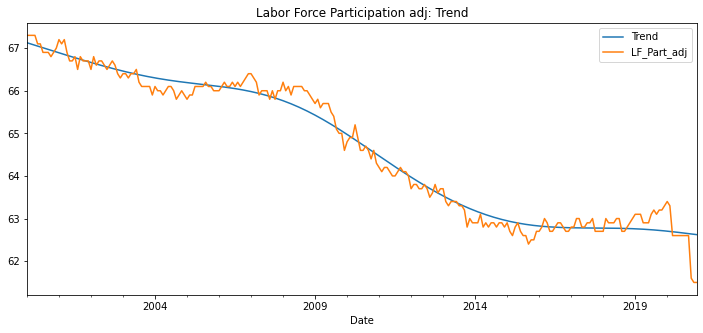

In [17]:
df[['Trend',target_index]].plot(figsize=(12,5),title=index_title + ': Trend')
plt.show()

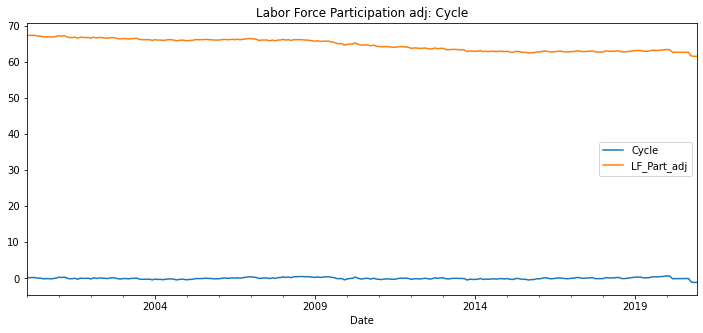

In [18]:
df[['Cycle',target_index]].plot(figsize=(12,5),title=index_title + ': Cycle')
plt.show()

In [19]:
#ETS

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,12

In [21]:
result_additive = seasonal_decompose(df[target_index], model = 'additive')

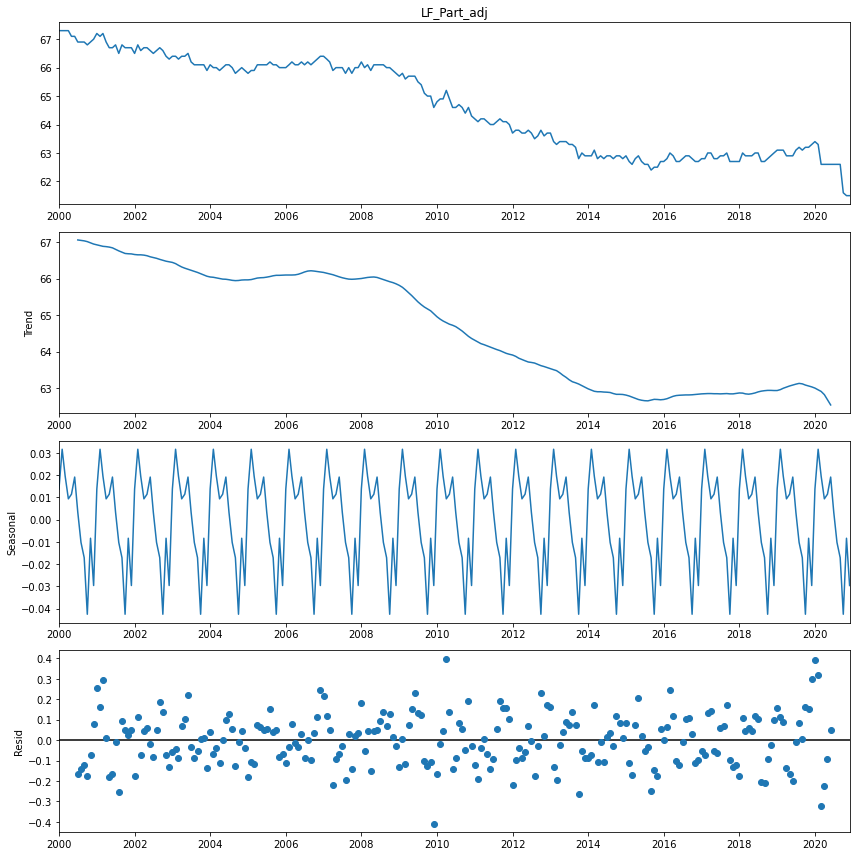

In [22]:
result_additive.plot();

In [23]:
result_multiplicative = seasonal_decompose(df[target_index], model = 'multiplicative')

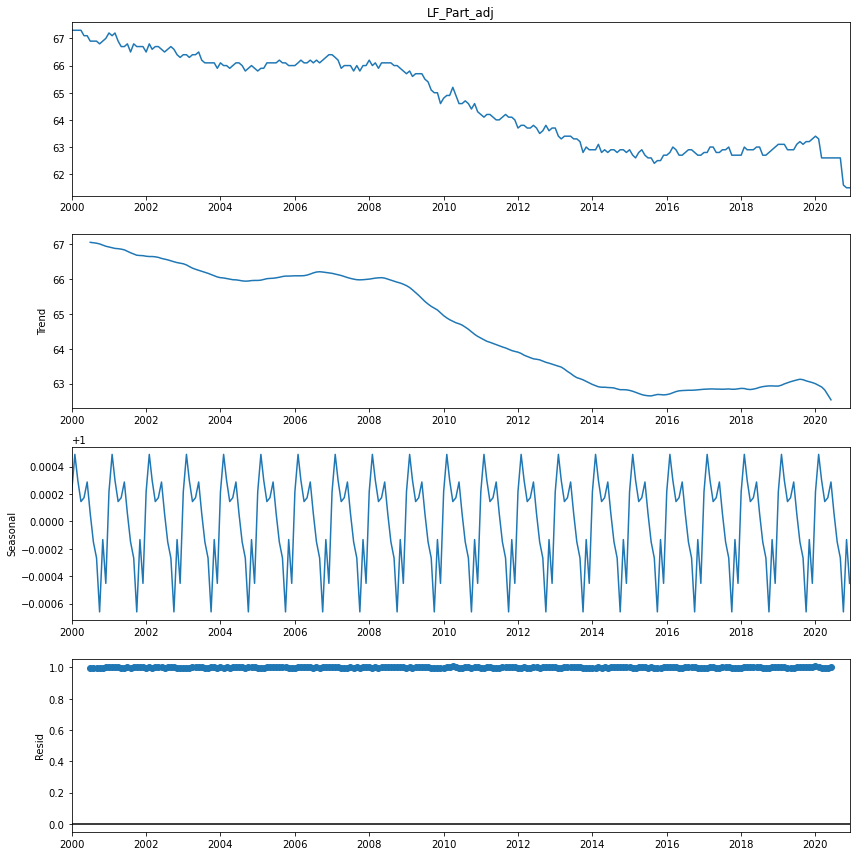

In [24]:
result_multiplicative.plot();

In [25]:
#EWMA

In [26]:
df['6-month--SMA']=df[target_index].rolling(window=6).mean()

In [27]:
df['12-month--SMA']=df[target_index].rolling(window=12).mean()

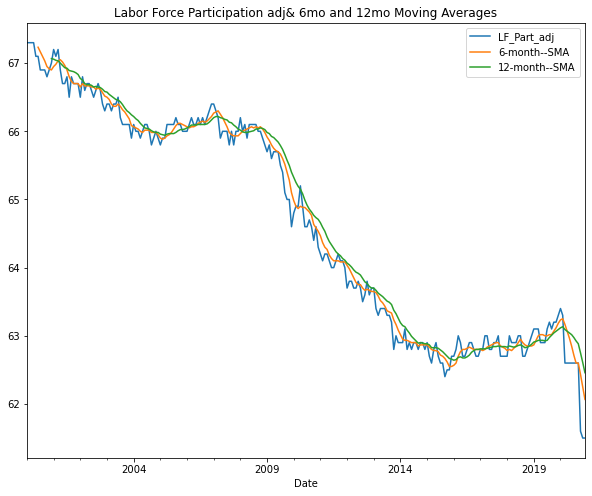

In [28]:
df[[target_index,'6-month--SMA','12-month--SMA']].plot(figsize=(10,8),title=index_title + '& 6mo and 12mo Moving Averages')
plt.show()

In [29]:
df['EWMA-12']=df[target_index].ewm(span=12, adjust=True).mean()

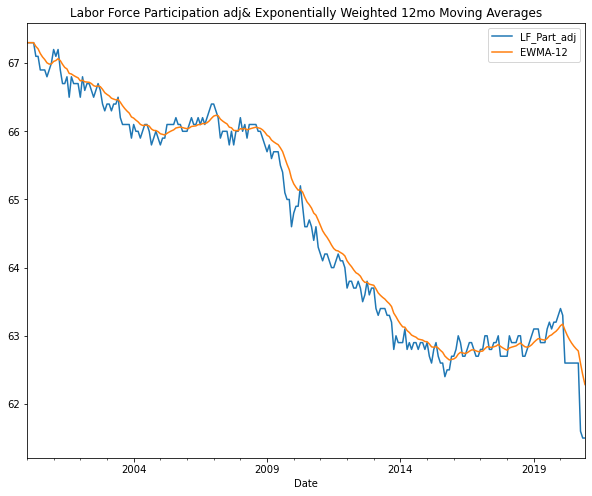

In [30]:
df[[target_index,'EWMA-12']].plot(figsize=(10,8),title=index_title + '& Exponentially Weighted 12mo Moving Averages')
plt.show()

In [31]:
#Holt-Winters method

In [32]:
df.index.freq= 'MS'

In [33]:
span = 12
alpha = 2/(span+1)

In [34]:
model = SimpleExpSmoothing(df[target_index])

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [35]:
fitted_model=model.fit(smoothing_level=alpha, optimized = False)

In [36]:
df['SES12']=fitted_model.fittedvalues.shift(-1)

In [37]:
model =  ExponentialSmoothing(df[target_index],trend='add')

In [38]:
fitted_model = model.fit()

In [39]:
df['DES_add_12']=fitted_model.fittedvalues.shift(-1)

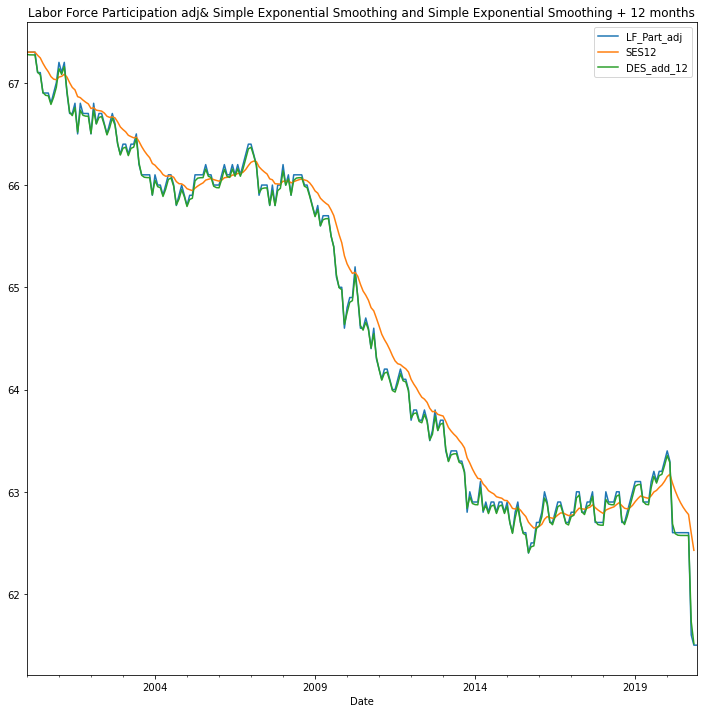

In [40]:
df[[target_index, 'SES12','DES_add_12']].plot(title=index_title + '& Simple Exponential Smoothing and Simple Exponential Smoothing + 12 months')
plt.show()

In [41]:
model =  ExponentialSmoothing(df[target_index],trend='add',seasonal='add', seasonal_periods=12)

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [42]:
fitted_model = model.fit()

In [43]:
df['TES_mul_12']=fitted_model.fittedvalues.shift(-1)

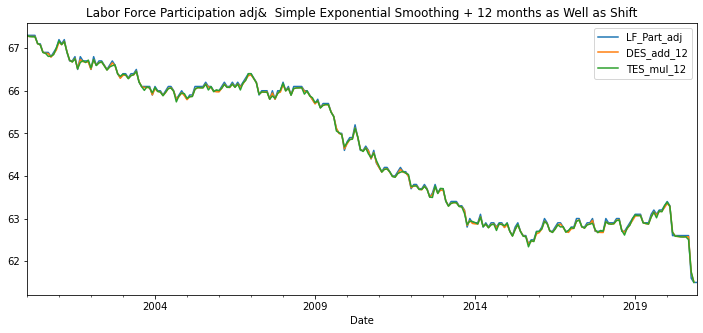

In [44]:
df[[target_index,'DES_add_12','TES_mul_12']].plot(figsize=(12,5),title=index_title + '&  Simple Exponential Smoothing + 12 months as Well as Shift')
plt.show()

In [45]:
df.drop(labels=['Trend','Cycle','6-month--SMA','12-month--SMA','EWMA-12','SES12','DES_add_12','TES_mul_12'],axis=1, inplace=True)

In [46]:
train_data=df.iloc[:201]
test_data=df.iloc[200:]

In [47]:
fitted_model=ExponentialSmoothing(train_data[target_index],
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [48]:
test_predictions=fitted_model.forecast(52)

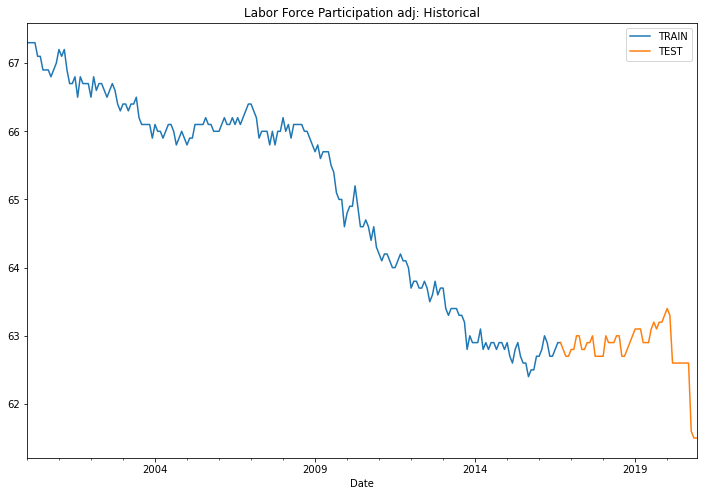

In [49]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Historical')
test_data[target_index].plot(legend=True, label='TEST')
plt.show()

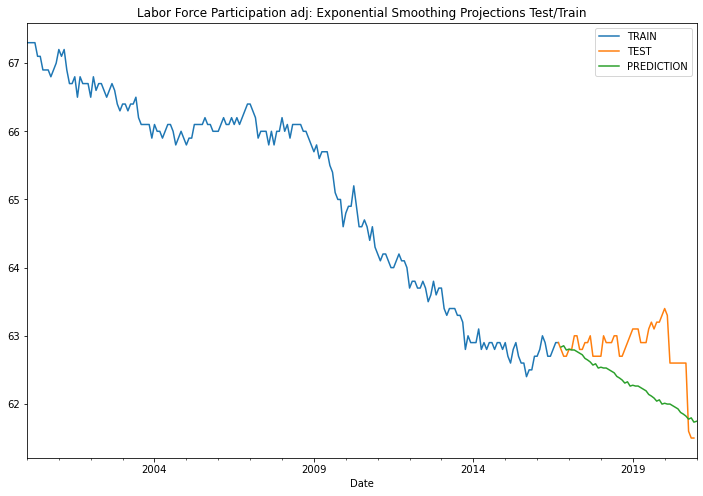

In [50]:
train_data[target_index].plot(legend=True, label='TRAIN', figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Test/Train')
test_data[target_index].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='PREDICTION')
plt.show()

In [51]:
## Evaulation

In [52]:
mean_absolute_error(test_data[target_index],test_predictions)

0.5387862431203417

In [53]:
mean_squared_error(test_data[target_index],test_predictions)

0.4306914012948819

In [54]:
np.sqrt(mean_squared_error(test_data[target_index],test_predictions))

0.6562708292274477

In [55]:
final_model=ExponentialSmoothing(df[target_index], 
                                 trend='add',
                                 seasonal='add',
                                 seasonal_periods=12).fit()

C:\Users\Jonathan\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [56]:
forecast_predictions=final_model.forecast(36)

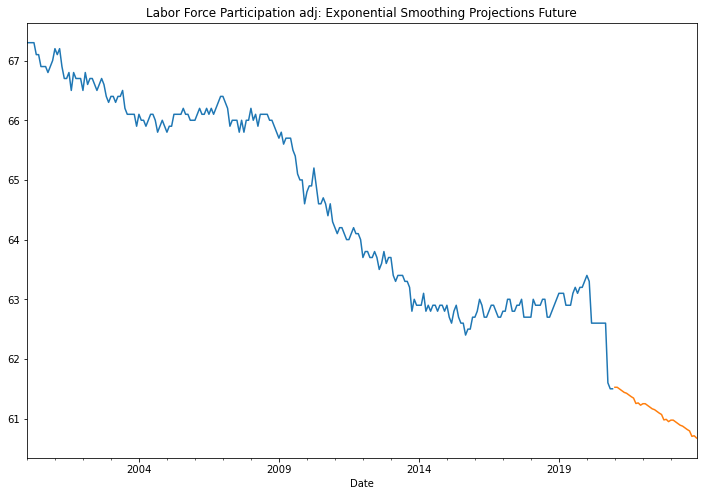

In [57]:
df[target_index].plot(figsize=(12,8),title=index_title + ': Exponential Smoothing Projections Future')
forecast_predictions.plot()
plt.show()

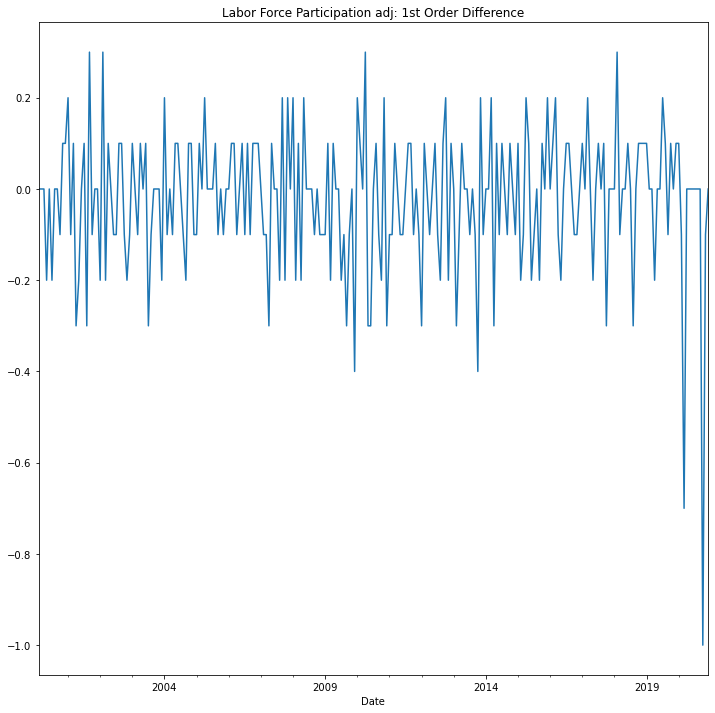

In [58]:
diff(df[target_index],k_diff=1).plot(title=index_title + ': 1st Order Difference')
plt.show()

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
#acf(df[target_index])

In [61]:
#pacf_yw(df[target_index], nlags=252, method='mle')

In [62]:
#pacf_ols(df[target_index], nlags=251)

In [63]:
from pandas.plotting import lag_plot

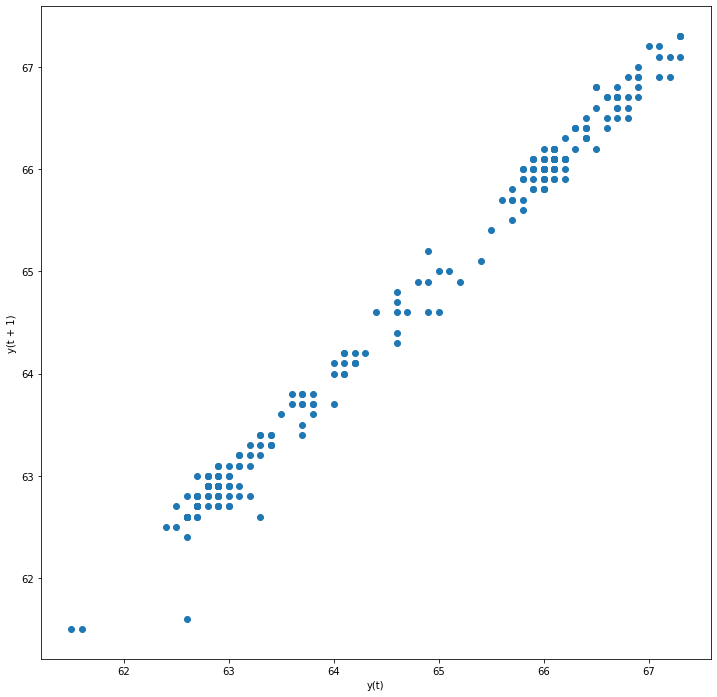

In [64]:
lag_plot(df[target_index])
plt.show()

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

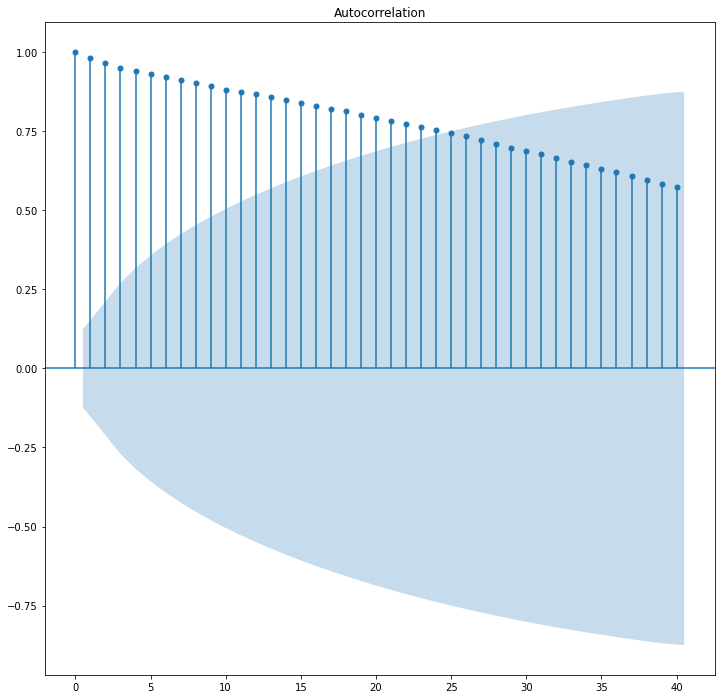

In [66]:
plot_acf(df[target_index],lags=40)
plt.show()

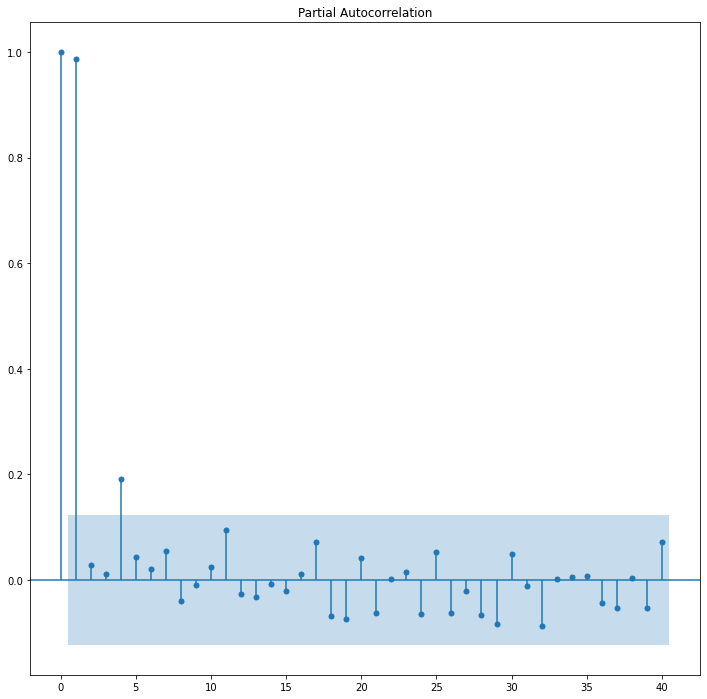

In [67]:
plot_pacf(df[target_index],lags=40)
plt.show()

In [68]:
#AR model

In [69]:
from statsmodels.tsa.ar_model import AR, ARResults

In [70]:
train =df.iloc[:200]

In [71]:
test =df.iloc[200:]

In [72]:
model = AR(train[target_index])

In [73]:
AR1fit = model.fit(maxlag=1)

In [74]:
AR1fit.aic

-3.9188765957644307

In [75]:
AR1fit.k_ar

1

In [76]:
AR1fit.params

const             0.246049
L1.LF_Part_adj    0.995884
dtype: float64

In [77]:
start=len(train)

In [78]:
end=len(train)+len(test)-1

In [79]:
#AR1fit.predict(start=start, end=end)

In [80]:
predictions1 = AR1fit.predict(start=start, end=end)

In [81]:
predictions1 = predictions1.rename('AR{1} Predictions')

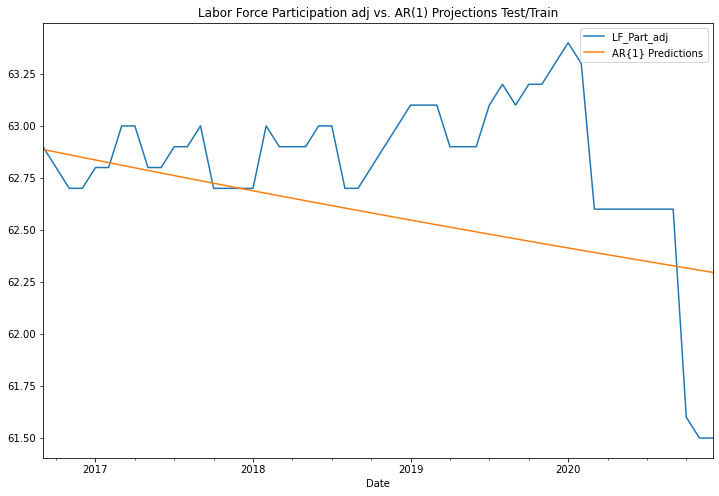

In [82]:
test[target_index].plot(figsize=(12,8),legend=True, title=index_title + ' vs. AR(1) Projections Test/Train')
predictions1.plot(legend=True);

In [83]:
model = AR(train[target_index])

In [84]:
AR2fit = model.fit(maxlag=2)

In [85]:
AR2fit.params

const             0.163328
L1.LF_Part_adj    0.753285
L2.LF_Part_adj    0.243781
dtype: float64

In [86]:
predictions2 = AR2fit.predict(start=start, end=end)

In [87]:
predictions2 = predictions2.rename('AR{2} Predictions')

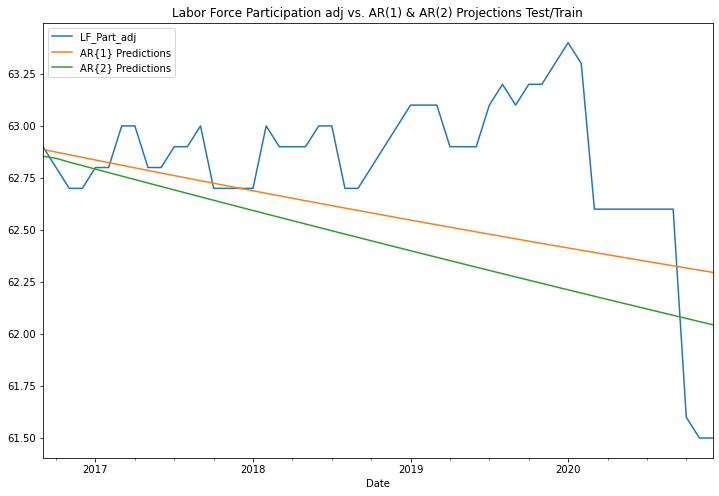

In [88]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1) & AR(2) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True);

In [89]:
model = AR(train[target_index])

In [90]:
ARfit = model.fit(ic='t-stat')

In [91]:
ARfit.params

const             0.030462
L1.LF_Part_adj    0.732101
L2.LF_Part_adj    0.180185
L3.LF_Part_adj   -0.002312
L4.LF_Part_adj    0.034522
L5.LF_Part_adj   -0.077940
L6.LF_Part_adj    0.132424
dtype: float64

In [92]:
predictions6=ARfit.predict(start,end)

In [93]:
predictions6=predictions6.rename('AR(6) Predictions')

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
labels = ['AR1','AR2','AR6']

In [96]:
preds = [predictions1,predictions2,predictions6]

In [97]:
for i in range(3):
    error = np.sqrt(mean_squared_error(test[target_index], preds[i]))
    print(f' {labels[i]} RMSE was: {error}')

 AR1 RMSE was: 0.4353699472594271
 AR2 RMSE was: 0.5335822487763235
 AR6 RMSE was: 0.6501452416453845


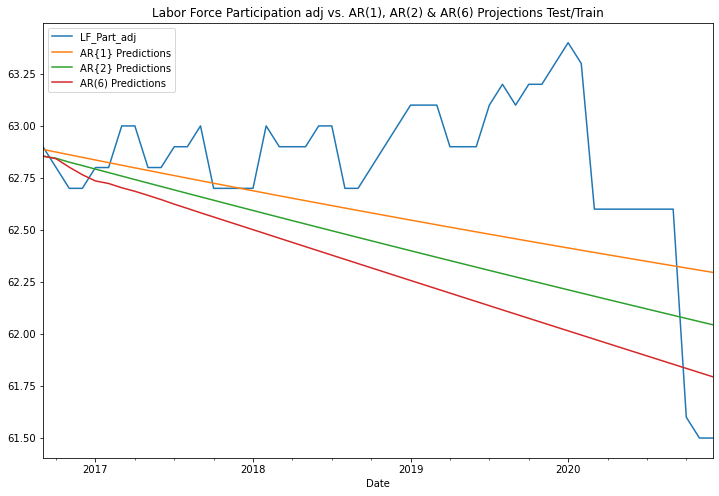

In [98]:
test[target_index].plot(figsize=(12,8),legend=True,title=index_title + ' vs. AR(1), AR(2) & AR(6) Projections Test/Train')
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions6.plot(legend=True);

In [99]:
#Forecasting

In [100]:
model=AR(df[target_index])

In [101]:
ARfit = model.fit(maxlag=13)

In [102]:
forcasted_values=ARfit.predict(start=len(df), end= len(df)+36).rename('Forecast')

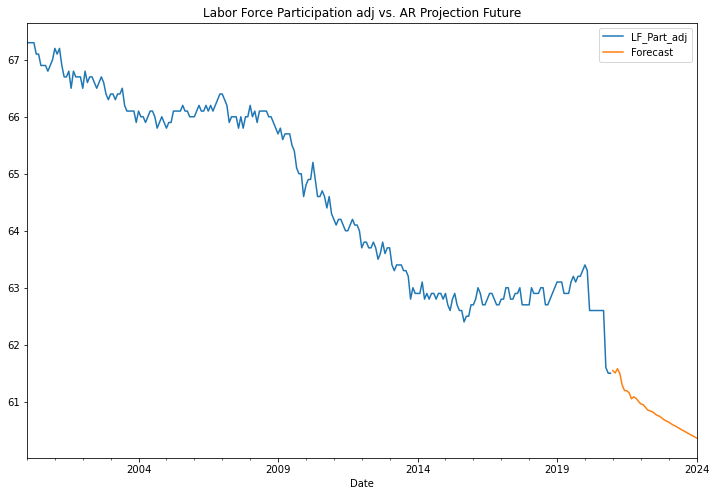

In [103]:
df[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. AR Projection Future')
forcasted_values.plot(legend=True)
plt.show()

In [104]:
#Descriptive statistics and tests

In [105]:
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin

In [106]:
dftest=adfuller(df[target_index])
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

In [107]:
for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

ADF test statistic       -0.231737
p-value                   0.934631
# lags used               1.000000
# observations          250.000000
critical value (1%)      -3.456781
critical value (5%)      -2.873172
critical value (10%)     -2.572969
dtype: float64


In [108]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [109]:
adf_test(df[target_index])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.231737
p-value                   0.934631
# lags used               1.000000
# observations          250.000000
critical value (1%)      -3.456781
critical value (5%)      -2.873172
critical value (10%)     -2.572969
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


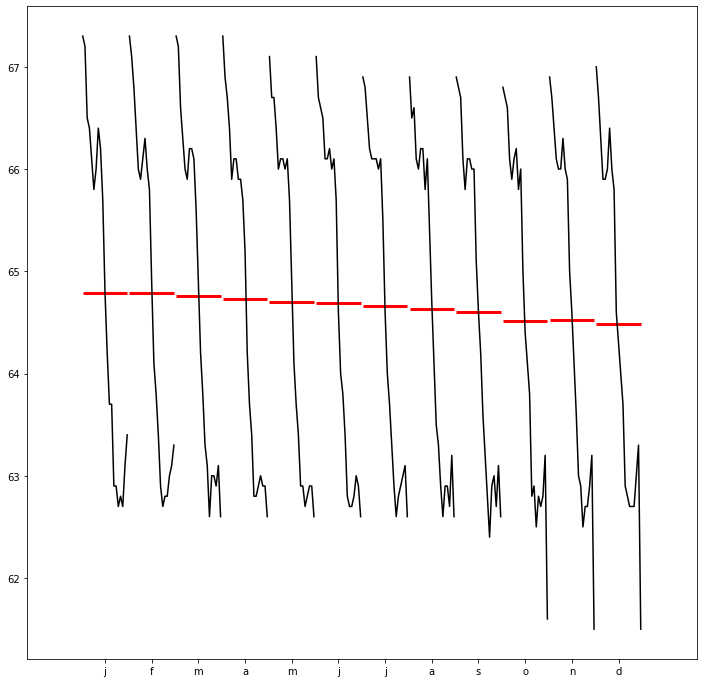

In [110]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
month_plot(df[target_index]);

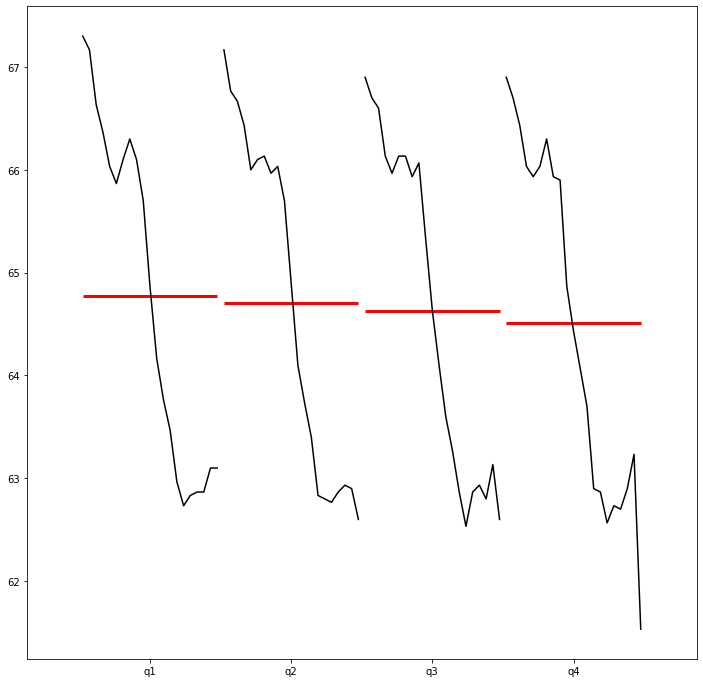

In [111]:
dfq = df[target_index].resample(rule='Q').mean()
quarter_plot(dfq);

In [112]:
#ARIMA orders

In [113]:
from pmdarima import auto_arima

In [114]:
stepwise_fit=auto_arima(df[target_index],start_p=0, start_q=0, max_p=6, max_q=3, seasonal = False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-224.814, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-227.737, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-228.315, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-221.182, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-228.424, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-226.424, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-226.424, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-227.200, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-226.353, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-224.707, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-220.939, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.090 seconds


In [115]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 118.212
Date:                Mon, 27 Sep 2021   AIC                           -228.424
Time:                        18:46:17   BIC                           -214.323
Sample:                             0   HQIC                          -222.750
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0121      0.007     -1.625      0.104      -0.027       0.002
ar.L1          0.4645      0.260      1.787      0.074      -0.045       0.974
ma.L1         -0.6218      0.233     -2.672      0.008      -1.078      -0.166
sigma2         0.0228      0.001     20.422      0.000       0.021       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               632.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [118]:
#ARMA

In [119]:
auto_arima(df[target_index], seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 118.212
Date:                Mon, 27 Sep 2021   AIC                           -228.424
Time:                        18:46:18   BIC                           -214.323
Sample:                             0   HQIC                          -222.750
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0121      0.007     -1.625      0.104      -0.027       0.002
ar.L1          0.4645      0.260      1.787      0.074      -0.045       0.974
ma.L1         -0.6218      0.233     -2.672      0.008      -1.078      -0.166
sigma2         0.0228      0.001     20.422      0.000       0.021       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               632.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
train = df.iloc[:200]
test = df.iloc[200:]

In [121]:
model=ARMA(train[target_index], order=(1,1,1))

In [122]:
results=model.fit()

In [123]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            LF_Part_adj   No. Observations:                  200
Model:                     ARMA(1, 1)   Log Likelihood                 110.343
Method:                       css-mle   S.D. of innovations              0.137
Date:                Mon, 27 Sep 2021   AIC                           -212.686
Time:                        18:46:19   BIC                           -199.493
Sample:                    01-01-2000   HQIC                          -207.347
                         - 08-01-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                65.0928      1.948     33.415      0.000      61.275      68.911
ar.L1.LF_Part_adj     0.9986      0.002    542.991      0.000       0.995       1.002
ma.L1.LF_Part_adj    -0.2107      0.068     -3.088      0.002      -0.344      -0.077
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0014           +0.0000j            1.0014            0.0000
MA.1            4.7465           +0.0000j            4.7465            0.0000
-----------------------------------------------------------------------------
"""

In [124]:
start=len(train)

In [125]:
end=len(train) +len(test)-1

In [126]:
predictions = results.predict(start,end,typ='levels').rename('ARMA (0,1) Prediction')

In [127]:
error=rmse(test[target_index],predictions)

In [128]:
error

0.4150030740228404

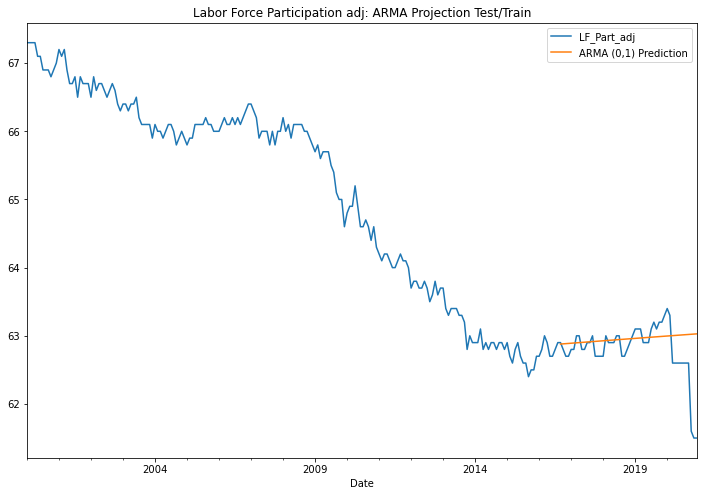

In [129]:
df[target_index].plot(figsize=(12,8), legend=True, title=index_title + ': ARMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [130]:
#ARIMA

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose

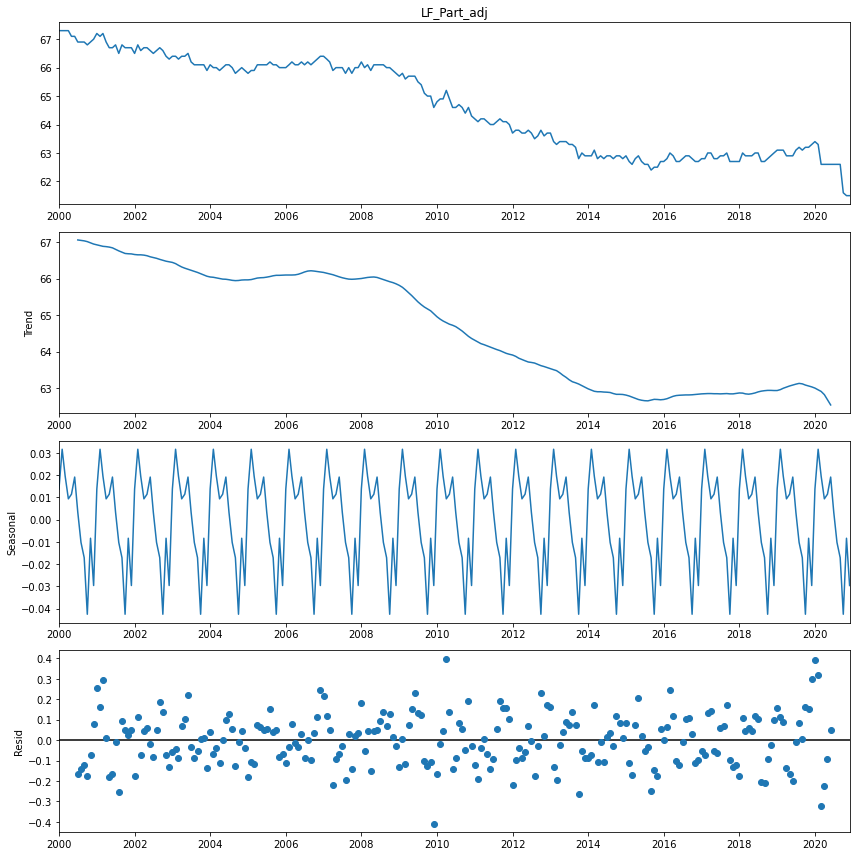

In [132]:
result = seasonal_decompose(df[target_index], model ='add')
result.plot();

In [133]:
auto_arima(df[target_index],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 118.212
Date:                Mon, 27 Sep 2021   AIC                           -228.424
Time:                        18:46:21   BIC                           -214.323
Sample:                             0   HQIC                          -222.750
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0121      0.007     -1.625      0.104      -0.027       0.002
ar.L1          0.4645      0.260      1.787      0.074      -0.045       0.974
ma.L1         -0.6218      0.233     -2.672      0.008      -1.078      -0.166
sigma2         0.0228      0.001     20.422      0.000       0.021       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               632.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
df['Diff_1'] =diff(df[target_index], k_diff=2)

In [135]:
adf_test(df['Diff_1'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.598022e+00
p-value                 6.991266e-14
# lags used             1.100000e+01
# observations          2.380000e+02
critical value (1%)    -3.458128e+00
critical value (5%)    -2.873762e+00
critical value (10%)   -2.573283e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


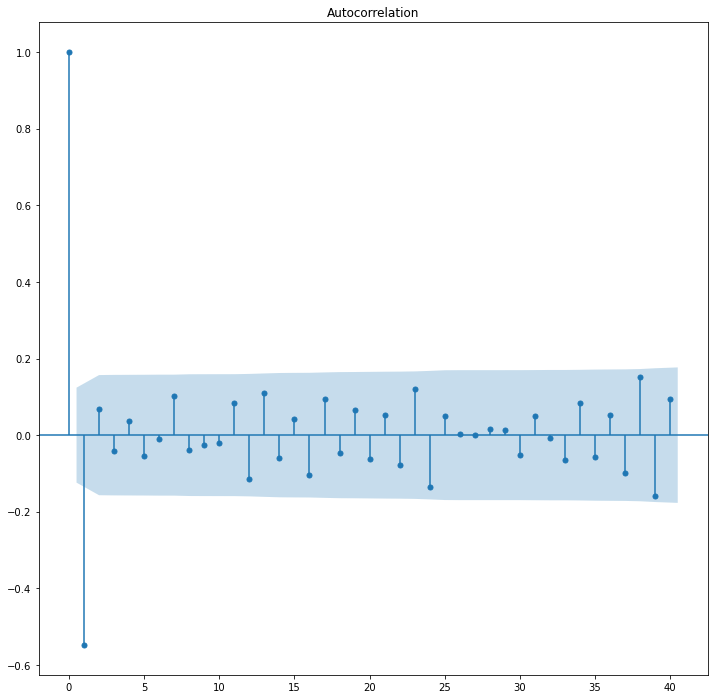

In [136]:
plot_acf(df['Diff_1'].dropna(),lags=40);

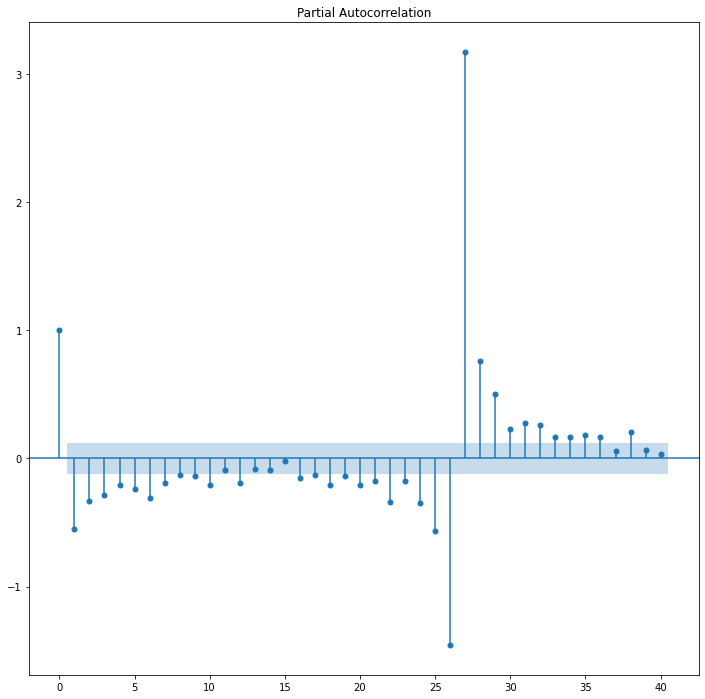

In [137]:
plot_pacf(df['Diff_1'].dropna(),lags=40);

In [138]:
stepwise_fit=auto_arima(df[target_index], start_p=0, start_q=0, max_p=12, max_q=12,
                       seasonal = False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-224.814, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-227.737, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-228.315, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-221.182, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-228.424, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-226.424, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-226.424, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-227.200, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-226.353, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-224.707, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-220.939, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.095 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 118.212
Date:                Mon, 27 Sep 2021   AIC                           -228.424
Time:                        18:46:22   BIC                           -214.323
Sample:                             0   HQIC                          -222.750
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0121      0.007     -1.625      0.104      -0.027       0.002
ar.L1          0.4645      0.260      1.787      0.074      -0.045       0.974
ma.L1         -0.6218      0.233     -2.672      0.008      -1.078      -0.166
sigma2         0.0228      0.001     20.422      0.000       0.021       0.025
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               632.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [139]:
train = df.iloc[:200]
test = df.iloc[200:]

In [140]:
model=ARIMA(train[target_index], order=(1,1,1))

In [141]:
results=model.fit()

In [142]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.LF_Part_adj   No. Observations:                  199
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 117.451
Method:                       css-mle   S.D. of innovations              0.134
Date:                Mon, 27 Sep 2021   AIC                           -226.903
Time:                        18:46:22   BIC                           -213.730
Sample:                    02-01-2000   HQIC                          -221.571
                         - 08-01-2016                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0224      0.006     -3.725      0.000      -0.034      -0.011
ar.L1.D.LF_Part_adj     0.2938      0.265      1.108      0.268      -0.226       0.814
ma.L1.D.LF_Part_adj    -0.5541      0.235     -2.354      0.019      -1.015      -0.093
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.4037           +0.0000j            3.4037            0.0000
MA.1            1.8048           +0.0000j            1.8048            0.0000
-----------------------------------------------------------------------------
"""

In [143]:
start=len(train)

In [144]:
end=len(train) +len(test)-1

In [145]:
predictions = results.predict(start,end, typ='levels').rename('ARIMA (1,1,1) Prediction')

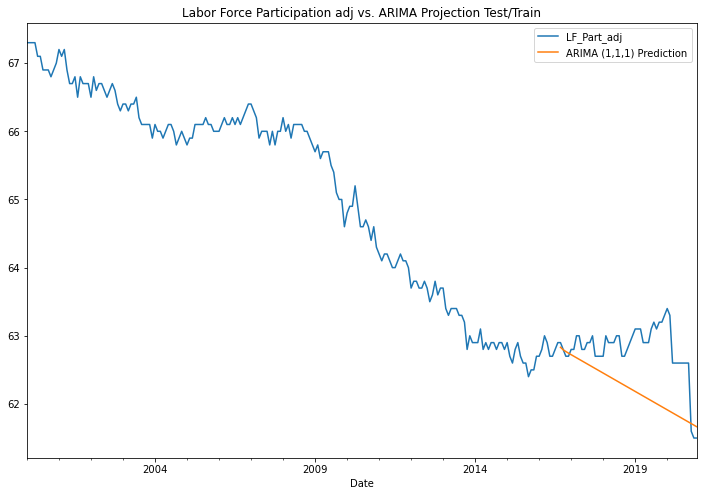

In [146]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Test/Train')
predictions.plot(legend=True)
plt.show()

In [147]:
error=rmse(test[target_index],predictions)

In [148]:
error

0.7147691734550344

In [149]:
#FORECAST

In [150]:
model=ARIMA(df[target_index], order=(1,1,1))

In [151]:
results=model.fit()

In [152]:
fcast=results.predict(start=len(df), end=len(df)+24,typ='levels').rename('ARIMA(0,1,2)')

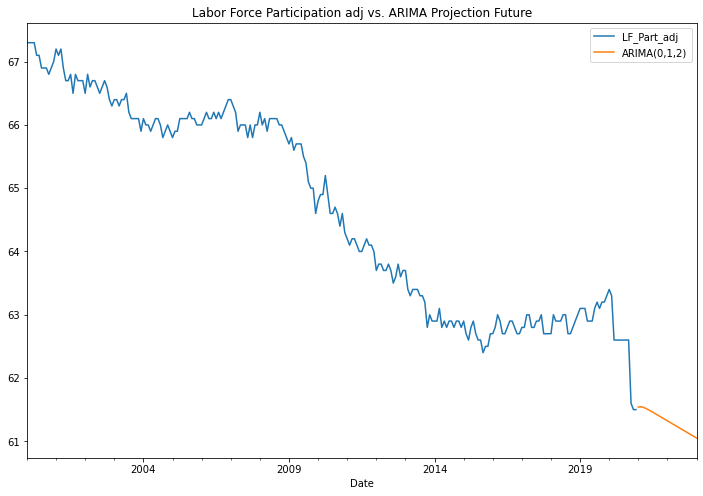

In [153]:
df[target_index].plot(legend=True, figsize=(12,8),title=index_title + ' vs. ARIMA Projection Future')
fcast.plot(legend=True);

In [154]:
#SARIMA Models

In [155]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose 

In [157]:
auto_arima(df[target_index], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  252
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 12)   Log Likelihood                 120.871
Date:                                 Mon, 27 Sep 2021   AIC                           -231.741
Time:                                         18:46:29   BIC                           -214.114
Sample:                                              0   HQIC                          -224.648
                                                 - 252                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0221      0.007     -3.111      0.002      -0.036      -0.008
ma.L1         -0.1523      0.066     -2.310      0.021      -0.281      -0.023
ma.S.L12      -0.0633      0.082     -0.770      0.442      -0.224       0.098
ma.S.L24      -0.2051      0.087     -2.368      0.018      -0.375      -0.035
sigma2         0.0222      0.001     19.582      0.000       0.020       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               596.34
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
train = df.iloc[:200]
test = df.iloc[200:]

In [159]:
model=SARIMAX(df[target_index], order=(0,1,1), seasonal_order=(0,0,[1],12))

In [160]:
results=model.fit()

In [161]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        LF_Part_adj   No. Observations:                  252
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                 113.392
Date:                            Mon, 27 Sep 2021   AIC                           -220.784
Time:                                    18:46:29   BIC                           -210.208
Sample:                                01-01-2000   HQIC                          -216.528
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1126      0.065     -1.734      0.083      -0.240       0.015
ma.S.L12      -0.0372      0.086     -0.434      0.664      -0.205       0.131
sigma2         0.0237      0.001     23.803      0.000       0.022       0.026
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               612.78
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.54
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
start=len(train)

In [163]:
end=len(train) +len(test)-1

In [164]:
predictions=results.predict(start, end,typ='levels').rename('SARIMA Predictions')

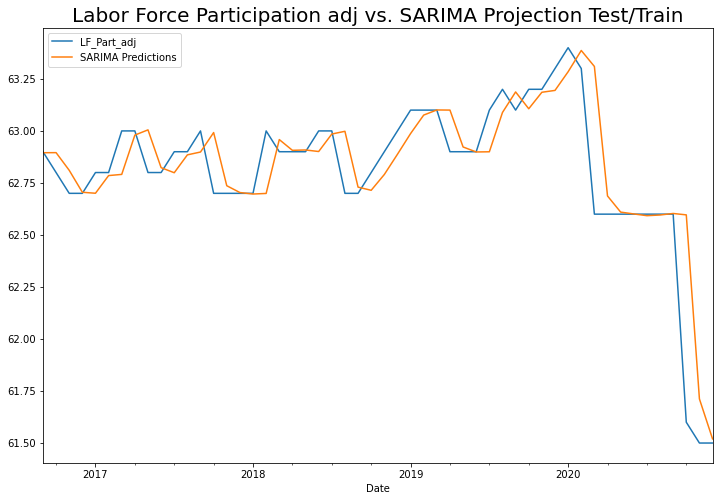

In [165]:
test[target_index].plot(legend=True, figsize=(12,8))
plt.title(index_title + ' vs. SARIMA Projection Test/Train', fontdict = {'fontsize' : 20})
predictions.plot(legend=True)
plt.savefig('image1.jpg');

In [166]:
error

0.7147691734550344

In [167]:
#Forecast

In [168]:
model= SARIMAX(df[target_index], order=(0,1,1), seasonal_order=(0,0,[1,2],12))
results=model.fit()

In [169]:
fcast= results.predict(start=len(df), end=len(df)+35,typ='levels').rename('SARIMA FORECAST')

In [170]:
len(fcast)

36

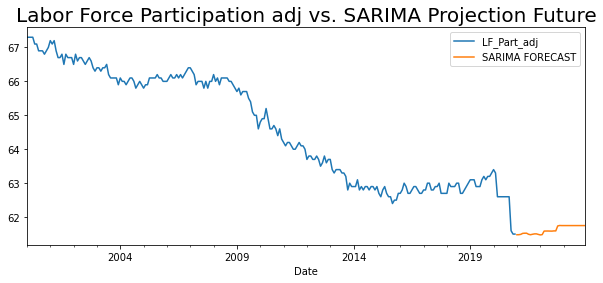

In [171]:
df[target_index].plot(legend=True, figsize=(10,4))
plt.title(index_title + ' vs. SARIMA Projection Future', fontdict = {'fontsize' : 20})
fcast.plot(legend=True)
plt.savefig('image2.jpg');

In [172]:
fcast

2021-01-01    61.480943
2021-02-01    61.481843
2021-03-01    61.491982
2021-04-01    61.521285
2021-05-01    61.525653
2021-06-01    61.525759
2021-07-01    61.493958
2021-08-01    61.480704
2021-09-01    61.494115
2021-10-01    61.505188
2021-11-01    61.506627
2021-12-01    61.490550
2022-01-01    61.475296
2022-02-01    61.483227
2022-03-01    61.588571
2022-04-01    61.589604
2022-05-01    61.590377
2022-06-01    61.588247
2022-07-01    61.587218
2022-08-01    61.593249
2022-09-01    61.593544
2022-10-01    61.740196
2022-11-01    61.753181
2022-12-01    61.750681
2023-01-01    61.750625
2023-02-01    61.750625
2023-03-01    61.750625
2023-04-01    61.750625
2023-05-01    61.750625
2023-06-01    61.750625
2023-07-01    61.750625
2023-08-01    61.750625
2023-09-01    61.750625
2023-10-01    61.750625
2023-11-01    61.750625
2023-12-01    61.750625
Freq: MS, Name: SARIMA FORECAST, dtype: float64

In [173]:
### Auto-ARIMA

In [174]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df[target_index], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-228.424, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-224.814, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-227.737, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-228.315, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-221.182, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-226.424, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-226.424, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-227.200, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-226.353, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-224.707, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-220.939, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.136 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

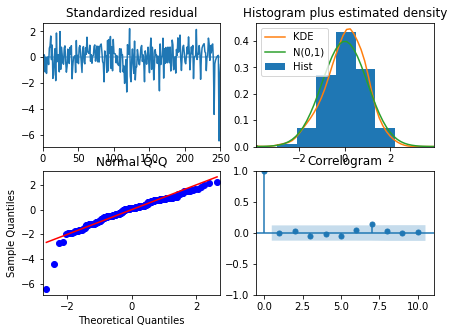

In [175]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [176]:
df[target_index]

Date
2000-01-01    67.3
2000-02-01    67.3
2000-03-01    67.3
2000-04-01    67.3
2000-05-01    67.1
              ... 
2020-08-01    62.6
2020-09-01    62.6
2020-10-01    61.6
2020-11-01    61.5
2020-12-01    61.5
Freq: MS, Name: LF_Part_adj, Length: 252, dtype: float64

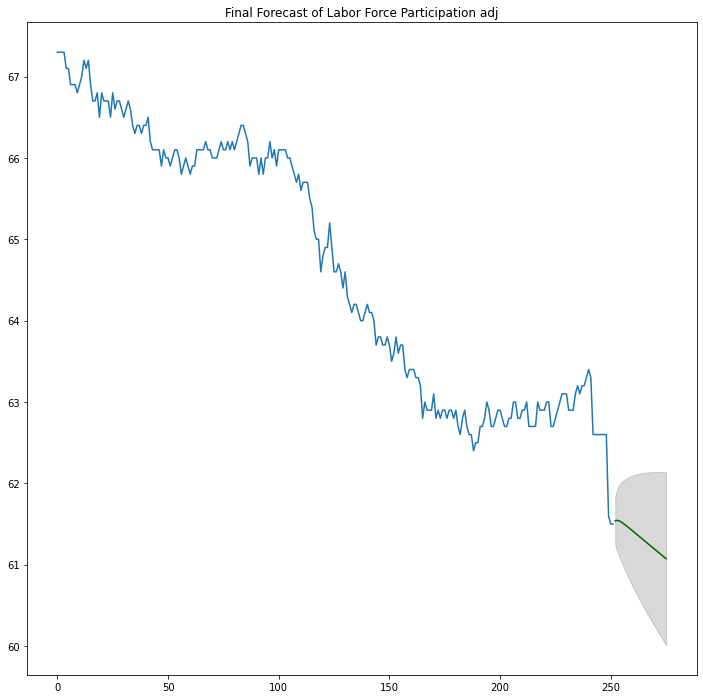

In [177]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df[target_index]), len(df[target_index])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

df.reset_index(inplace=True)

# Plot
plt.plot(df[target_index])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of " + index_title)
plt.show()

In [178]:
fc_series.to_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/UNEMPLOY_adj', header=False)

In [179]:
###Keras

In [180]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [181]:
from keras.models import Sequential
from keras.layers import Dense

In [182]:
model = Sequential()
# 4 Neurons, expecting only 1 feature with input_dim=1
model.add(Dense(4, input_dim=1, activation='relu'))
# 4 Neurons (Play around with this number!)
model.add(Dense(4, activation='relu'))
# One final output of y, so only 1 neuron
model.add(Dense(1, activation='linear'))
# Compil the layers
model.compile(loss='mse', optimizer='adam')

In [183]:
df=df.reset_index()

In [184]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [185]:
model.fit(df.index, df[target_index], epochs=500, verbose=1)

Epoch 1/500
8/8 [==============================] - 0s 997us/step - loss: 3387.4167
Epoch 2/500
8/8 [==============================] - 0s 997us/step - loss: 3060.1340
Epoch 3/500
8/8 [==============================] - 0s 1ms/step - loss: 2758.0034
Epoch 4/500
8/8 [==============================] - 0s 932us/step - loss: 2479.0298
Epoch 5/500
8/8 [==============================] - 0s 1ms/step - loss: 2221.4241
Epoch 6/500
8/8 [==============================] - 0s 1ms/step - loss: 2000.4025
Epoch 7/500
8/8 [==============================] - 0s 997us/step - loss: 1805.1803
Epoch 8/500
8/8 [==============================] - 0s 1ms/step - loss: 1641.4375
Epoch 9/500
8/8 [==============================] - 0s 1ms/step - loss: 1506.5428
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 1395.4745
Epoch 11/500
8/8 [==============================] - 0s 1ms/step - loss: 1311.0176
Epoch 12/500
8/8 [==============================] - 0s 1ms/step - loss: 1251.0283
Epoch 13/500
8/8 

8/8 [==============================] - 0s 1ms/step - loss: 1073.5618
Epoch 98/500
8/8 [==============================] - 0s 1ms/step - loss: 1072.8500
Epoch 99/500
8/8 [==============================] - 0s 1ms/step - loss: 1071.9819
Epoch 100/500
8/8 [==============================] - 0s 1ms/step - loss: 1071.5189
Epoch 101/500
8/8 [==============================] - 0s 996us/step - loss: 1070.6016
Epoch 102/500
8/8 [==============================] - 0s 1ms/step - loss: 1069.8212
Epoch 103/500
8/8 [==============================] - 0s 997us/step - loss: 1069.1298
Epoch 104/500
8/8 [==============================] - 0s 1ms/step - loss: 1068.3121
Epoch 105/500
8/8 [==============================] - 0s 937us/step - loss: 1067.6538
Epoch 106/500
8/8 [==============================] - 0s 1ms/step - loss: 1066.7183
Epoch 107/500
8/8 [==============================] - 0s 931us/step - loss: 1065.9080
Epoch 108/500
8/8 [==============================] - 0s 1ms/step - loss: 1065.6168
Epoch 109/50

8/8 [==============================] - 0s 1ms/step - loss: 994.7775
Epoch 196/500
8/8 [==============================] - 0s 1ms/step - loss: 993.9639
Epoch 197/500
8/8 [==============================] - 0s 1ms/step - loss: 993.1850
Epoch 198/500
8/8 [==============================] - 0s 1ms/step - loss: 991.9757
Epoch 199/500
8/8 [==============================] - 0s 1ms/step - loss: 991.5035
Epoch 200/500
8/8 [==============================] - 0s 1ms/step - loss: 990.5004
Epoch 201/500
8/8 [==============================] - 0s 1ms/step - loss: 989.6933
Epoch 202/500
8/8 [==============================] - 0s 1ms/step - loss: 989.2097
Epoch 203/500
8/8 [==============================] - 0s 1ms/step - loss: 988.3417
Epoch 204/500
8/8 [==============================] - 0s 1ms/step - loss: 987.0628
Epoch 205/500
8/8 [==============================] - 0s 1ms/step - loss: 986.3464
Epoch 206/500
8/8 [==============================] - 0s 1ms/step - loss: 985.3710
Epoch 207/500
8/8 [===========

8/8 [==============================] - 0s 1ms/step - loss: 906.1219
Epoch 295/500
8/8 [==============================] - 0s 1ms/step - loss: 905.2709
Epoch 296/500
8/8 [==============================] - 0s 1ms/step - loss: 904.1037
Epoch 297/500
8/8 [==============================] - 0s 1ms/step - loss: 903.3270
Epoch 298/500
8/8 [==============================] - 0s 1ms/step - loss: 902.8409
Epoch 299/500
8/8 [==============================] - 0s 1ms/step - loss: 901.6953
Epoch 300/500
8/8 [==============================] - 0s 1ms/step - loss: 900.0602
Epoch 301/500
8/8 [==============================] - 0s 1ms/step - loss: 899.6237
Epoch 302/500
8/8 [==============================] - 0s 1ms/step - loss: 898.8375
Epoch 303/500
8/8 [==============================] - 0s 1ms/step - loss: 897.6448
Epoch 304/500
8/8 [==============================] - 0s 1ms/step - loss: 896.6438
Epoch 305/500
8/8 [==============================] - 0s 1ms/step - loss: 896.0820
Epoch 306/500
8/8 [===========

8/8 [==============================] - 0s 993us/step - loss: 804.1998
Epoch 394/500
8/8 [==============================] - 0s 1ms/step - loss: 802.6417
Epoch 395/500
8/8 [==============================] - 0s 1ms/step - loss: 801.3098
Epoch 396/500
8/8 [==============================] - 0s 1ms/step - loss: 800.3897
Epoch 397/500
8/8 [==============================] - 0s 1ms/step - loss: 799.9964
Epoch 398/500
8/8 [==============================] - 0s 1ms/step - loss: 797.9671
Epoch 399/500
8/8 [==============================] - 0s 1ms/step - loss: 797.1138
Epoch 400/500
8/8 [==============================] - 0s 997us/step - loss: 795.6463
Epoch 401/500
8/8 [==============================] - 0s 997us/step - loss: 794.5610
Epoch 402/500
8/8 [==============================] - 0s 998us/step - loss: 793.3514
Epoch 403/500
8/8 [==============================] - 0s 997us/step - loss: 792.5406
Epoch 404/500
8/8 [==============================] - 0s 1ms/step - loss: 791.2675
Epoch 405/500
8/8 [=

8/8 [==============================] - 0s 1ms/step - loss: 679.8024
Epoch 493/500
8/8 [==============================] - 0s 1ms/step - loss: 677.9828
Epoch 494/500
8/8 [==============================] - 0s 997us/step - loss: 676.3329
Epoch 495/500
8/8 [==============================] - 0s 996us/step - loss: 675.2443
Epoch 496/500
8/8 [==============================] - 0s 1ms/step - loss: 674.0026
Epoch 497/500
8/8 [==============================] - 0s 998us/step - loss: 672.2416
Epoch 498/500
8/8 [==============================] - 0s 997us/step - loss: 670.7881
Epoch 499/500
8/8 [==============================] - 0s 804us/step - loss: 669.6544
Epoch 500/500
8/8 [==============================] - 0s 570us/step - loss: 667.7549


In [186]:
x_for_predictions = np.linspace(0,252,1000)

In [187]:
y_predicted = model.predict(x_for_predictions)

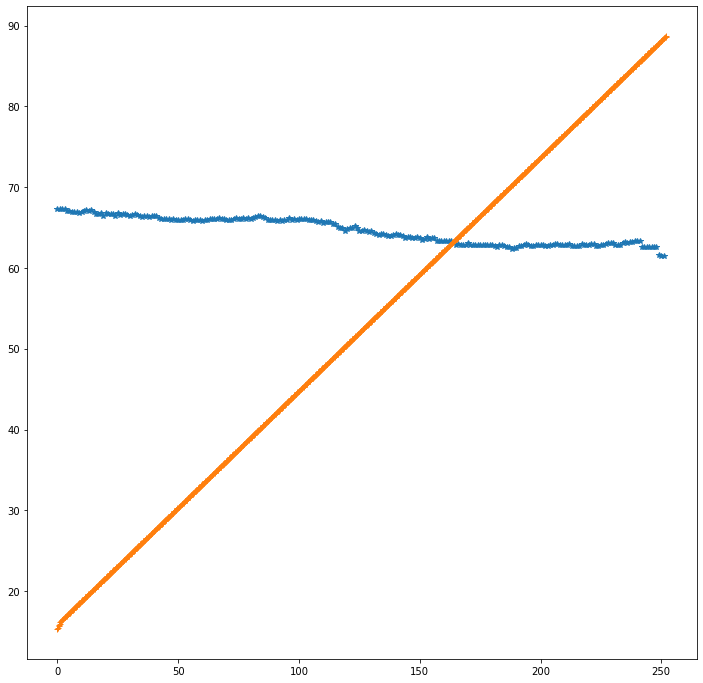

In [188]:
# Original X and Y
plt.plot(df.index, df[target_index],'*')
# Our Model's prediction Line
plt.plot(x_for_predictions,y_predicted,'+')

In [189]:
# start full Keras

In [190]:
df = pd.read_csv('C:/Users/Jonathan/Desktop/Springboard_Course/Save to folder/time_series_dataframe.csv', index_col=1,parse_dates=True)

In [191]:
df=df.reset_index()

In [192]:
df.drop(labels=(['Date','Unnamed: 0','Y30_fixed_mortgage_rate','CS_HPA_20_cities','LF_Part','CS_HP','Y10_CMT', 'UNEMPLOY','UNEMPLOY_adj']),axis=1,inplace=True)

In [193]:
train_len = len(df)-36

In [194]:
train = df.iloc[:train_len]
test = df.iloc[train_len:]

In [195]:
from sklearn.preprocessing import MinMaxScaler

In [196]:
scaler = MinMaxScaler()

In [197]:
scaler.fit(train)

MinMaxScaler()

In [198]:
scaled_train = scaler.transform(train)

In [199]:
scaled_test = scaler.transform(test)

In [200]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [201]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [202]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [203]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [204]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150)               91200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [205]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
204/204 [==============================] - 1s 2ms/step - loss: 0.0165
Epoch 2/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 3/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 4/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 5/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 6/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 7/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 8/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 9/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 10/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 11/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 12/30
204/204 [==============================] - 0s 2ms/step - loss: 0.0015
Epoch 13/30
204/204 [====

In [206]:
model.history.history.keys()

dict_keys(['loss'])

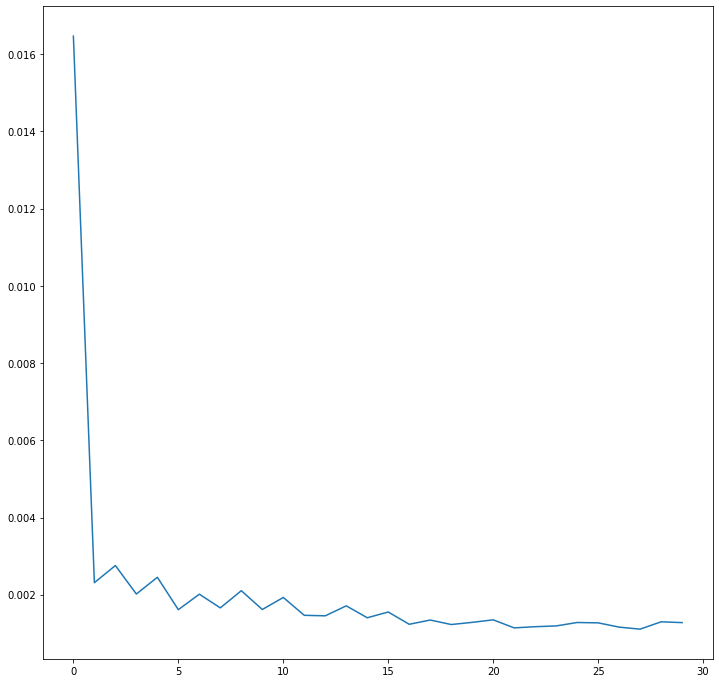

In [207]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.show()

In [208]:
first_eval_batch = scaled_train[-12:]

In [209]:
first_eval_batch

array([[0.08163265],
       [0.08163265],
       [0.12244898],
       [0.12244898],
       [0.08163265],
       [0.08163265],
       [0.10204082],
       [0.10204082],
       [0.12244898],
       [0.06122449],
       [0.06122449],
       [0.06122449]])

In [210]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [211]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [212]:
true_predictions = scaler.inverse_transform(test_predictions)

In [213]:
true_predictions

array([[62.77733672],
       [62.78537754],
       [62.79402074],
       [62.80290499],
       [62.81171631],
       [62.81920071],
       [62.82545388],
       [62.83070868],
       [62.83488828],
       [62.83861912],
       [62.84022127],
       [62.84118343],
       [62.84166285],
       [62.84199606],
       [62.84207024],
       [62.84197748],
       [62.84178913],
       [62.84155851],
       [62.84132005],
       [62.84109413],
       [62.84089407],
       [62.84072471],
       [62.84058872],
       [62.84048117],
       [62.84039906],
       [62.84033853],
       [62.84029611],
       [62.84026796],
       [62.84025058],
       [62.84024117],
       [62.8402373 ],
       [62.84023711],
       [62.84023919],
       [62.84024252],
       [62.84024635],
       [62.84025026]])

In [214]:
test['Predictions'] = true_predictions

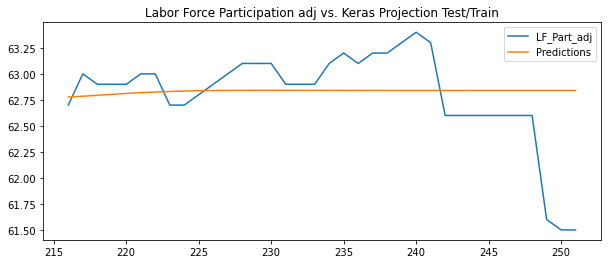

In [215]:
test.plot(figsize=(10,4),title=index_title + ' vs. Keras Projection Test/Train')
plt.show()

In [216]:
error=rmse(test[target_index],test['Predictions'])

In [217]:
print(error)

0.44754648252427937


In [218]:
### Keras projection

In [219]:
train_len = len(df)

In [220]:
train = df.iloc[:train_len]

In [221]:
scaler.fit(train)

MinMaxScaler()

In [222]:
scaled_train = scaler.transform(train)

In [223]:
n_input=12
n_features =1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [224]:
# define model
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [225]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [226]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0121
Epoch 2/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 3/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 4/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 5/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0019
Epoch 6/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 7/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0020
Epoch 8/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 9/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0017
Epoch 10/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0016
Epoch 11/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 12/30
240/240 [==============================] - 1s 2ms/step - loss: 0.0014
Epoch 13/30
240/240 [====

In [227]:
model.history.history.keys()

dict_keys(['loss'])

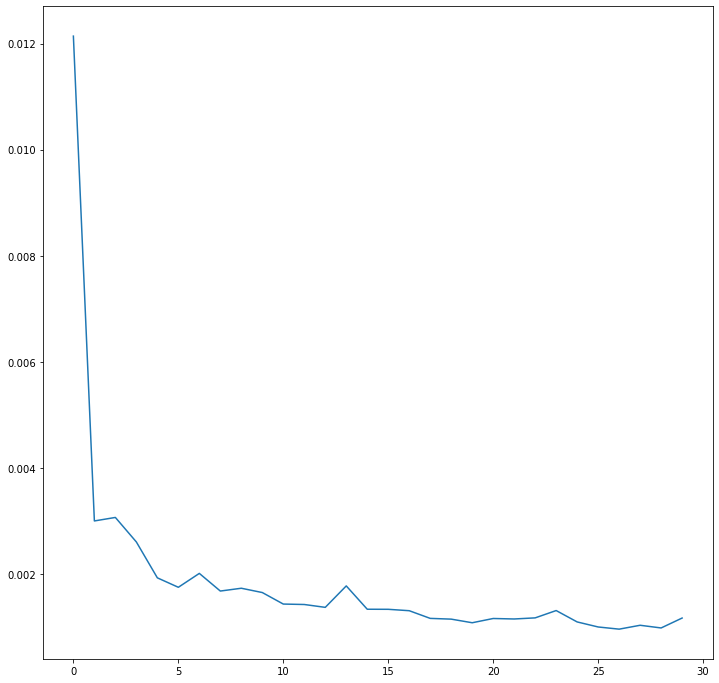

In [228]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [229]:
first_eval_batch = scaled_train[-12:]

In [230]:
first_eval_batch

array([[0.32758621],
       [0.31034483],
       [0.18965517],
       [0.18965517],
       [0.18965517],
       [0.18965517],
       [0.18965517],
       [0.18965517],
       [0.18965517],
       [0.01724138],
       [0.        ],
       [0.        ]])

In [231]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [232]:
future_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(36):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    future_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [233]:
true_predictions = scaler.inverse_transform(test_predictions)

In [234]:
projections=pd.DataFrame(true_predictions)

In [235]:
projections.index = np.arange(252, 252+36)

In [236]:
projections=projections.rename(columns={0: 'LF_Part_adj:Proj.'})

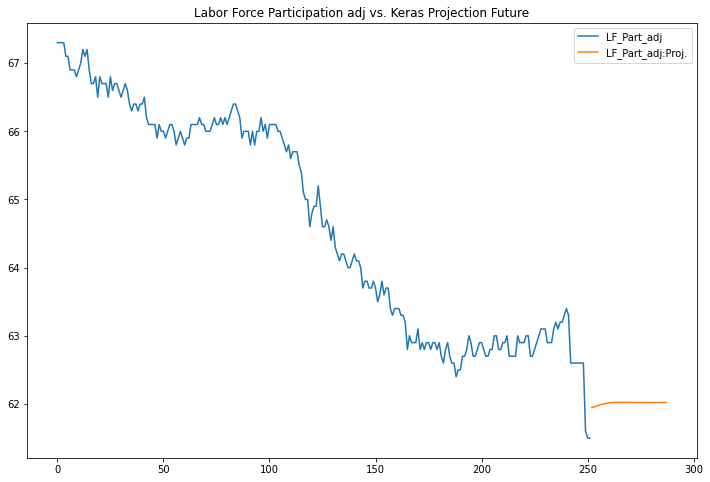

In [237]:
train[target_index].plot(figsize=(12,8), legend=True,title=index_title + ' vs. Keras Projection Future')
projections['LF_Part_adj:Proj.'].plot(legend=True)
plt.show()